In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Objectives:

We want to look at bandits where the rewards are only 1 or 0 (Bernouilli).


1) COMPLETE the code where it says "COMPLETE".

2) Do simulations for a bandit with 2 arms P = [0.4, 0.8] for each of the mentionned decision rule and plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret. 

3) Do simulations with a bandit with 10 arms (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]). Plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret.  
Play with the c parameter in UCB.

4) Study the dependence of the hyperparameter epsilon in the decision rule epsilon-greedy.

5) What are your conclusions in terms of methods? Give some intution.



In [2]:
class BernoulliBanditEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # Best action given env

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [3]:
class Agent(object):
    # Class which defines the agent. Each agent has a decision rule and a learning rule.
    
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
        
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]
    
    def environment(self, env, init_q):
        # initialize environment
        self.env = env                                  
        self.k = env.num_arms                           
        self.actions = np.arange(self.k)                
        self.act_count = np.zeros(self.k)               
        self.iteration = 0     
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))

    def learn(self, a, r):
        # given action and reward, update value function.
        if self.learning_rule == "averaging":
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])
            
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a] += 1 - r 
            
    def act(self):
        # action.
        self.iteration += 1 
        if self.decision_rule == "greedy":
            selected_action = np.argmax(self.q_estimate)
            pass

        if self.decision_rule == "epsilon-greedy":
            if np.random.rand() < self.epsilon:
                # Explore: Choose a random action
                selected_action = np.random.choice(self.actions)
            else:
                # Exploit: Choose the action with the highest estimated value
                selected_action = np.argmax(self.q_estimate)
            pass
        
        if self.decision_rule == "UCB":
            exploration_bonus = np.sqrt(2 * np.log(self.iteration) / (self.act_count))
            ucb_values = self.q_estimate + self.UCB_param * exploration_bonus
            selected_action = np.argmax(ucb_values)
            pass

        # if self.decision_rule == "Thompson":
        #     # Assuming Beta distribution for BayesianBetaPrior
        #     sampled_means = np.random.beta(self.alpha, self.beta)
        #     selected_action = np.argmax(sampled_means)
        #     pass
    
        self.act_count[selected_action] += 1
        return selected_action

In [4]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=1000, N=100):
    # function that simulates the agents behaviour
    # agents is a list of agents.
    
    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

In [15]:
def plot_results(agents, actions, rewards):
    # function that plots for each agent:
    # the corresponding  mean reward;
    # the mean cumulative reward and the percentage of times the best arm was elected as time goes by

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, agent in enumerate(agents):
        ax[0].plot(rewards[i, :], label=agent.decision_rule)
        ax[1].plot(np.cumsum(rewards[i, :]), label=agent.decision_rule)
        ax[2].plot(actions[i, :], label=agent.decision_rule)
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Mean reward')
    ax[0].legend()
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Mean cumulative reward')
    ax[1].legend()
    ax[2].set_xlabel('Iteration')
    ax[2].set_ylabel('% Optimal action')
    ax[2].legend()
    plt.show()

In [16]:
T = 1000
N = 2000

### Question 2

C:\Users\mouta\AppData\Local\Temp\ipykernel_8240\2860274705.py:55: RuntimeWarning: invalid value encountered in divide
  exploration_bonus = np.sqrt(2 * np.log(self.iteration) / (self.act_count))
C:\Users\mouta\AppData\Local\Temp\ipykernel_8240\2860274705.py:55: RuntimeWarning: divide by zero encountered in divide
  exploration_bonus = np.sqrt(2 * np.log(self.iteration) / (self.act_count))


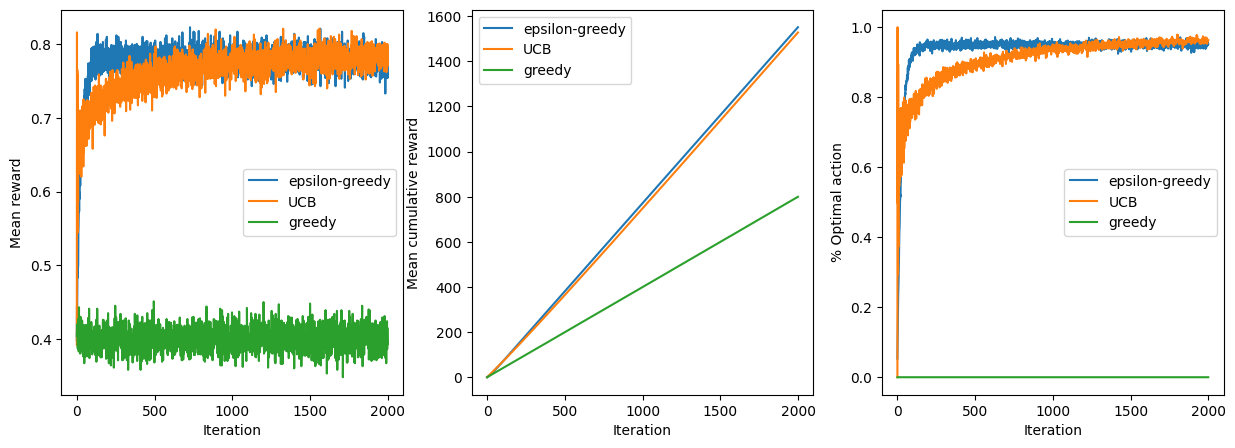

In [18]:
agen = Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon": 0.1})

agen2 = Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param": 2})

agen3 = Agent(learning_rule="BayesianBetaPrior", decision_rule="greedy")

nb_arms = 2
p_init = [0.4, 0.8]

[rewards, actions] = simulateBandits([agen, agen2, agen3], narms=nb_arms, initp=p_init, repetitions=T, N=N)

plot_results([agen, agen2, agen3], actions, rewards)

#### Interpretation :
Unfortunately the greedy method is not the best one. Indeed, it is not able to explore the other arms and therefore it is not able to find the best arm. It uses the same arm all the time and randomly used the wrong one at first and now is stuck with it.

The epsilon-greedy method is better than the greedy one because it is able to explore the other arms.
The UCB method is the best one because it is able to explore the other arms and exploit the best arm. Indeed, it is able to find the best arm and at the 2000th iteration it is mostly using the best arm. Hence, overtaking the epsilon-greedy method.

### Question 3

C:\Users\mouta\AppData\Local\Temp\ipykernel_8240\2860274705.py:55: RuntimeWarning: invalid value encountered in divide
  exploration_bonus = np.sqrt(2 * np.log(self.iteration) / (self.act_count))
C:\Users\mouta\AppData\Local\Temp\ipykernel_8240\2860274705.py:55: RuntimeWarning: divide by zero encountered in divide
  exploration_bonus = np.sqrt(2 * np.log(self.iteration) / (self.act_count))


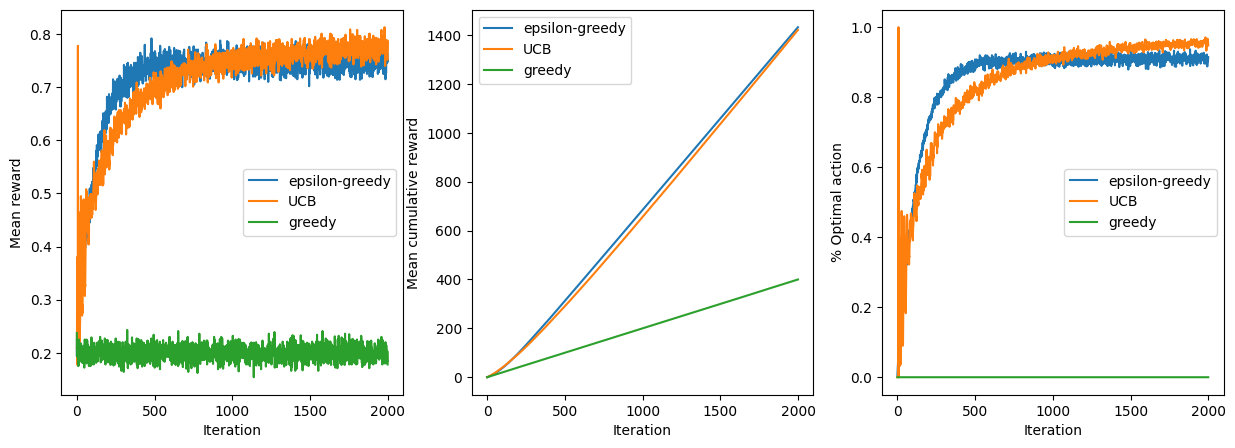

In [22]:
agen = Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon": 0.1})

agen2 = Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param": 1})

agen3 = Agent(learning_rule="BayesianBetaPrior", decision_rule="greedy")

nb_arms = 10
p_init = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]

[rewards, actions] = simulateBandits([agen, agen2, agen3], narms=nb_arms, initp=p_init, repetitions=T, N=N)

plot_results([agen, agen2, agen3], actions, rewards)

### Interpretation :

The same conclusion can be drawn for the 10 arms bandit.
However, if the parameter for the UCB method is too high, it will take a lot of time to exploit the best arm. Hence it might not be le to overtake the epsilon-greedy method. Here, c = 1 ensures that the UCB method is the best one.

### Question 4

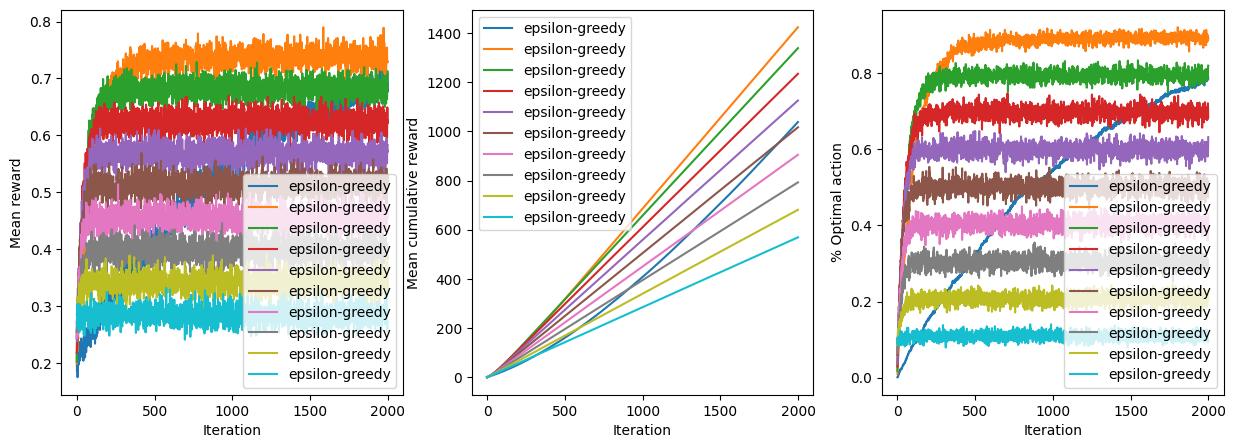

In [24]:
epsilon = np.linspace(0.01, 0.99, 10)

agents = [ Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon": eps}) for eps in epsilon ]

nb_arms = 10
p_init = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]

[rewards, actions] = simulateBandits(agents, narms=nb_arms, initp=p_init, repetitions=T, N=N)

plot_results(agents, actions, rewards)